# Ptychography Tutorial 00

This notebook uses the abtem-legacy package to simulate the three ducky datasets we'll use in the iterative ptychography tutorial series.

### Downloads
This tutorial uses the following files:
- [ducky_coords.mat](https://drive.google.com/file/d/1CmCLdHy6ISKPt10bwYlMoLf4ieSjPtAl/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2024 May 6

In [51]:
!pip uninstall abtem

^C


In [1]:
import numpy as np
import py4DSTEM
# import abtem
import ase
import h5py
import os 
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
sys.path.append(r'C:\\github\\abTEMlegacy')
sys.path.append(r'C:\\github\\abTEMlegacy\\abtem')


cupyx.jit.rawkernel is experimental. The interface can change in the future.


In [2]:


import abTEMlegacy.abtem as abtem 

from emdfile import tqdmnd
from abtem.scan import PositionScan
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage import rotate

print(abtem.__version__)

1.0.0beta34


### Atomic Model

First, we import the atomic coordinates and create the atomic simulation environment (ASE) Atoms object.

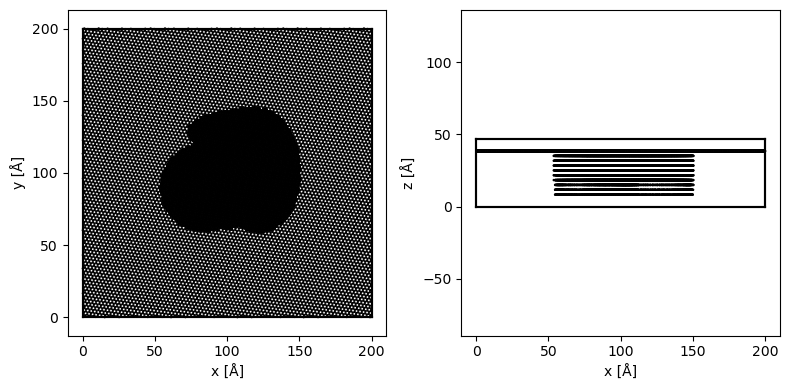

In [35]:
with h5py.File("../data/Ducky Coordinates.mat","r") as f:
    atoms = f['atoms'][:].T
    cell_dim = f['cell_dim'][:].ravel()

ducky_atoms = ase.Atoms(
    numbers=atoms[:,-1],
    positions=atoms[:,:3],
    cell=np.array([200,200,atoms[:,2].max() + atoms[:,2].min()])
)

fig, axs = plt.subplots(1,2,figsize=(8,4))

abtem.show_atoms(ducky_atoms,ax=axs[0])
abtem.show_atoms(ducky_atoms,plane='xz',ax=axs[1])

fig.tight_layout()
plt.show()

### Potential and Probe

Next, we build the multi-sliced potential object, and a 20mrad probe with 500 A defocus

In [4]:
abtem.CTF(
        semiangle_cutoff=20,
        defocus=500,
    )

In [9]:
abtem.Potential(ducky_atoms,
    sampling=0.1,
    slice_thickness=0.5,
    parametrization='kirkland',
    projection='infinite',
    device=None,).build()

AttributeError: 'NoneType' object has no attribute 'mem_info'

In [12]:
potential = abtem.Potential(
    ducky_atoms,
    sampling=0.1,
    slice_thickness=0.5,
    parametrization='kirkland',
    projection='infinite',
    device='cpu',
).build()


In [36]:

parameters = {
    'C10': -750 ,
    'C30': -8e4 ,
    'C50': 5e7 ,
    'C12': 0,
    'phi12': np.deg2rad(0),

    'C23': 200,
    'phi23': np.deg2rad(0),

}


In [37]:

probe_01 = abtem.Probe(
    energy=300e3,
    semiangle_cutoff=30,
    parameters=parameters,
    device='gpu',
)


In [38]:

probe_01.match_grid(potential)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    
potential.project().show(
    ax=ax1,
    cmap='magma',
)

probe_01.show(ax =ax2);

fig.tight_layout()

### 4D-STEM Simulation

Next, we define a pixelated detector and raster scan to perform the simulation.  
_Note:_ We specify `max_angle=None` and the default `resample` to obtain a 4D-dataset with the same dimensions as the potential (which we will later crop/bin)

In [39]:
probe_01.ctf.nyquist_sampling

0.1640624074810639

In [40]:
pixelated_detector = abtem.PixelatedDetector(
    max_angle=None,
)
grid_scan_01 = abtem.GridScan(
    start = [20, 20], 
    end = [180,180],
    sampling=4,
)

measurement_01 = probe_01.scan(
    scan = grid_scan_01,
    detectors = pixelated_detector,
    potential = potential,
)

Scan:   0%|          | 0/1600 [00:00<?, ?it/s]

Looking at the mean diffraction pattern, we can see the effect of the 2/3 antialiasing filter used by abtem.

In [41]:
pixelated_measurement = measurement_01

In [42]:
measurement_01.shape

(40, 40, 2000, 2000)

In [13]:
cmap = 'turbo'
fig,ax = plt.subplots(1,4,figsize=(12,4))
ax[0].imshow(
    np.mean(pixelated_measurement.array, axis = (0,1))**0.5,
    cmap = cmap,
)
ax[1].imshow(
    pixelated_measurement.array[0,0],
    cmap = cmap,
)
ax[2].imshow(
    pixelated_measurement.array[1,0],
    cmap = cmap,
)
ax[3].imshow(
    pixelated_measurement.array[2,0],
    cmap = cmap,
)

ax[0].axis('off');
ax[1].axis('off');
ax[2].axis('off');
ax[3].axis('off');
fig.tight_layout()

KeyboardInterrupt: 

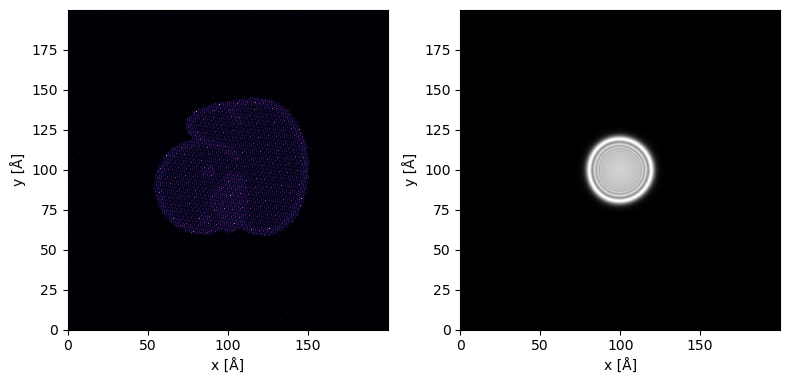

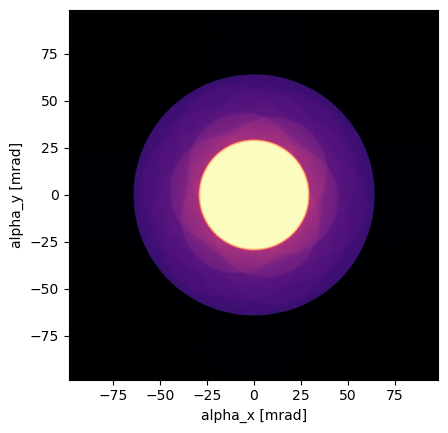

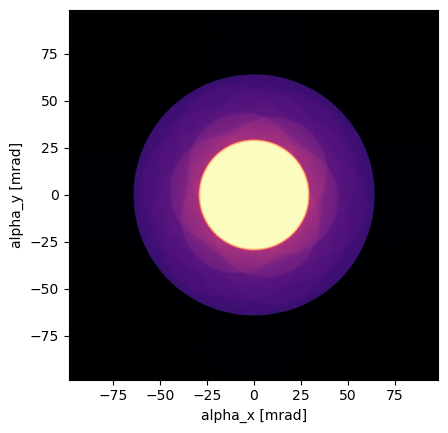

In [44]:
measurement_01.mean((0,1)).show(power=0.125,cmap='magma');
plt.show()

### Experimental artifacts
Finally, we add common experimental artifacts like residual descan, rotation, and Poisson shot noise.

In [45]:
# plane-wave descan
sx, sy, qx, qy = measurement_01.shape
bin_factor = 5

x = np.linspace(-80,80,sx)
y = np.linspace(-80,80,sy)

descan_x = np.round((y[None,:]-2*x[:,None]) / grid_scan_01.calibrations[0].sampling)
descan_y = np.round((-y[None,:]-3*x[:,None]) / grid_scan_01.calibrations[0].sampling)

py4DSTEM.show(
    [
        descan_x/bin_factor,
        descan_y/bin_factor
    ],
    vmin=0,
    vmax=1,
    cmap='PiYG',
    axsize=(4,4),
    show_cbar=True,
    ticks=False,
    title=["Descan vertical (pixels)","Descan horizontal (pixels)"]
)

In [46]:
descan_y[5,6]

58.0

In [47]:
array_01 = np.zeros((sx,sy,200,200),dtype=measurement_01.array.dtype)
for i,j in tqdmnd(sx,sy):
    
    dp = measurement_01.array[i,j]
    dp = rotate(dp,15,reshape=False,order=1) # rotate
    dp = np.roll(dp,(int(descan_x[i,j]),int(descan_y[i,j])),axis=(0,1)) # descan
    dp = dp[500:-500,500:-500].reshape((200,5,200,5)).sum((1,3)) # bin
    array_01[i,j] = dp

array_sums_01 = array_01.sum((-2,-1))
print(f"Smallest array sum (should be close to 1): {array_sums_01.min()}")

# poisson noise
electron_dose = 1e5 # e/A^2
electron_dose_per_probe_01 = electron_dose * grid_scan_01.calibrations[0].sampling**2

np.random.seed(2024)
array_01 = np.random.poisson((array_01 * electron_dose_per_probe_01).clip(0)).astype(np.uint64)


100%|██████████| 1600/1600 [05:36<00:00,  4.75it/s]


Smallest array sum (should be close to 1): 0.9996963739395142


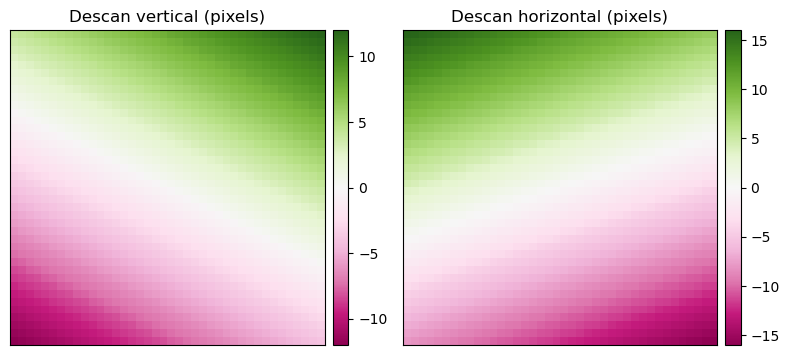

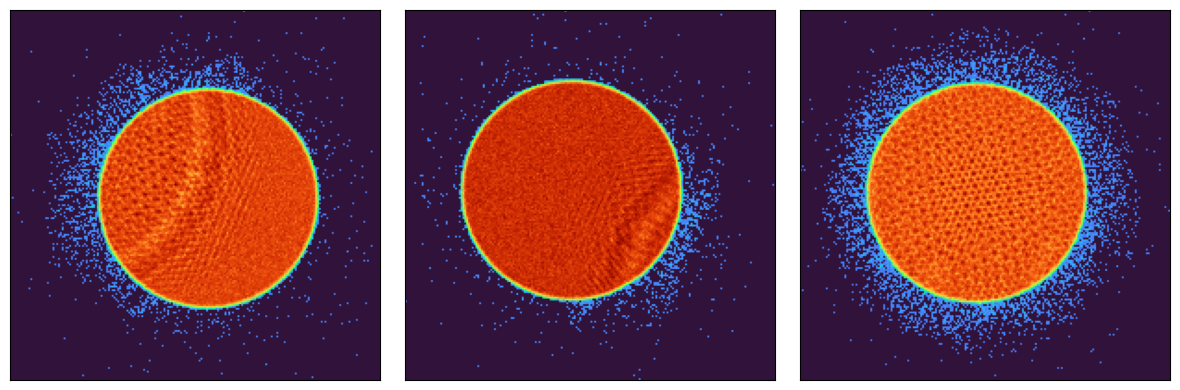

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.025
             R_pixel_size:    4.0
             Q_pixel_units:   A^-1
             R_pixel_units:   A
             QR_flip:         False
)

In [48]:

py4DSTEM.show(
    [
        array_01[11,11],
        array_01[32,32],
        array_01[25,25],
    ],
    cmap='turbo',
    vmax=1,
    power=0.333,
    axsize=(4,4),
    ticks=False,
)
plt.show()

dataset_01 = py4DSTEM.DataCube(array_01)
dataset_01.calibration.set_Q_pixel_size(0.025)
dataset_01.calibration.set_Q_pixel_units('A^-1')
dataset_01.calibration.set_R_pixel_size(grid_scan_01.calibrations[0].sampling)
dataset_01.calibration.set_R_pixel_units('A')
dataset_01.calibration

### Vacuum scan
We also need to perform a vacuum measurement, using the same steps as above (no need for rotation, descan).

In [49]:
import cupy as cp

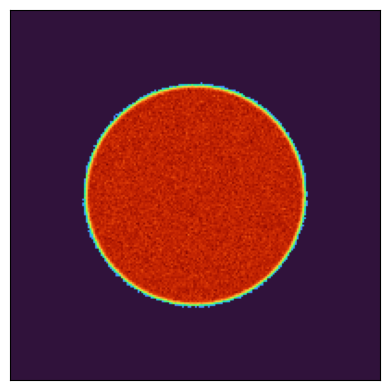

In [50]:
position_scan = PositionScan([[0,0]])
empty_potential = potential.copy()

xp = cp.get_array_module(empty_potential._array)
empty_potential._array = xp.zeros_like(empty_potential._array)

vacuum_probe_01 = probe_01.scan(
    position_scan,
    pixelated_detector,
    empty_potential,
    pbar=False
)[0]

vacuum_probe_01 = vacuum_probe_01.array
vacuum_probe_01 = vacuum_probe_01[500:-500,500:-500].reshape((200,5,200,5)).sum((1,3))
vacuum_probe_01 = np.random.poisson((vacuum_probe_01 * electron_dose_per_probe_01).clip(0)).astype(np.uint64)

py4DSTEM.show(
    vacuum_probe_01,
    cmap='turbo',
    vmax=1,
    power=0.333,
    figsize=(4,4),
    ticks=False,
)
plt.show()

### Save Simulations

Finally, we save our simulated dataset

In [51]:
py4DSTEM.save("..//data//ptycho_ducky_simulation_02.h5",dataset_01,mode='o')
py4DSTEM.save("..//data//ptycho_ducky_vacuum-probe_02.h5",py4DSTEM.VirtualDiffraction(vacuum_probe_01),mode='o')

### Rinse and Repeat

We then perform the simulation twice more for the following settings:

- simulation 01:
  - defocus: 500A, step-size 5A
- simulation 02:
  - defocus: 600A, step-size 5A
- simulation 03:
  - defocus: 500A, step-size 4A